In [1]:
import sympy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

import dataset
import dataset_feynman1d
import dataset_feynman2d
import dataset_physics
import dataset_misc1d
import dataset_misc2d
import dataset_misc3d
import space
from backprop import library, project, diversify
from gp import gp
from gp import creator as gp_creator
from gp import evaluator as gp_evaluator, selector as gp_selector
from gp import crossover as gp_crossover, mutator as gp_mutator
from gp import corrector as gp_corrector
from symbols import syntax_tree
import randstate

In [2]:
SAMPLE_SIZE = 200
TRAIN_SIZE  = 0.7
NOISE       = 0.#05
MESH_SIZE   = 100

POPSIZE          = 100
MAX_STREE_DEPTH  = 5
MAX_STREE_LENGTH = 20
GENERATIONS      = 50
GROUP_SIZE       = 5  # tournament selector.
MUTATION_RATE    = 0.15
ELITISM          = 1

LIBSIZE       = 2000
LIB_MAXDEPTH  = 3
LIB_MAXLENGTH = 10

RANDSTATE = None#124

In [3]:
randstate.setstate(RANDSTATE)

#S = dataset_misc1d.MagmanDatasetScaled()
S = dataset_misc2d.Resistance2()
#S = dataset_misc1d.ABSDataset()
#S = dataset_misc3d.Gravity()
#S = dataset_feynman2d.FeynmanICh6Eq20()
#S = dataset_feynman1d.FeynmanIICh27Eq16()
#S = dataset_physics.AircraftLift()

S.sample(size=SAMPLE_SIZE, noise=NOISE, mesh=False)
#S.load('../data/magman.csv')

S.split(train_size=TRAIN_SIZE)
#S.get_plotter().plot(width=8, height=6, plot_knowldege=False)

S_train = dataset.NumpyDataset(S)
S_test  = dataset.NumpyDataset(S, test=True)

In [4]:
np.seterr(all='ignore')

syntax_tree.SyntaxTreeInfo.set_problem(S_train)

y_iqr = S_train.get_y_iqr()
solutionCreator = gp_creator.PTC2RandomSolutionCreator(nvars=S.nvars, y_iqr=y_iqr)

multiMutator = gp_mutator.MultiMutator(
      gp_mutator.SubtreeReplacerMutator(MAX_STREE_DEPTH, MAX_STREE_LENGTH, solutionCreator),
      gp_mutator.FunctionSymbolMutator(),
      gp_mutator.NumericParameterMutator(all=True, y_iqr=y_iqr),
      #gp.NumericParameterMutator(all=False, y_iqr=y_iqr)
      )

mesh           = space.MeshSpace(S_train, S.knowledge, MESH_SIZE)
know_evaluator = gp_evaluator.KnowledgeEvaluator(S.knowledge, mesh)
r2_evaluator   = gp_evaluator.R2Evaluator(S_train)
evaluator      = gp_evaluator.LayeredEvaluator(know_evaluator, r2_evaluator)

selector  = gp_selector.TournamentSelector(GROUP_SIZE)
crossover = gp_crossover.SubTreeCrossover(MAX_STREE_DEPTH, MAX_STREE_LENGTH)
corrector = gp_corrector.Corrector(S_train, S.knowledge, MAX_STREE_DEPTH, MAX_STREE_LENGTH, mesh, LIBSIZE, LIB_MAXDEPTH, LIB_MAXLENGTH, solutionCreator)

symb_regressor = \
         gp.GP(POPSIZE, GENERATIONS, MAX_STREE_DEPTH, MAX_STREE_LENGTH, S_train, S_test,
               creator=solutionCreator,
               evaluator=evaluator,
               selector=selector,
               crossover=crossover,
               mutator=multiMutator,
               corrector=corrector,
               mutrate=MUTATION_RATE,
               elitism=ELITISM,
               knowledge=S.knowledge)

import profiling

with tqdm(total=symb_regressor.ngen-1) as pbar:
      def on_newgen(genidx, status):
            pbar.update(1)
            pbar.set_description(status)
      best_stree, best_eval = symb_regressor.evolve(newgen_callback=on_newgen)

profiling.print_stats()

print("\n--- Best syntax tree ---")
print(best_stree)
print(best_eval)
print(f"Max depth: {best_stree.get_max_depth()}")
print(f"Length: {best_stree.get_nnodes()}")
#if corrector is not None: print(f"Lib radius faults: {corrector.lib.get_radius_faults()}")

  0%|          | 0/49 [00:00<?, ?it/s]

         1677484 function calls (1473447 primitive calls) in 4.636 seconds

   Ordered by: cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
     4900    0.109    0.000    4.626    0.001 corrector.py:28(correct)
     4900    0.071    0.000    2.633    0.001 corrector.py:80(backprop_know)
     4891    0.088    0.000    1.146    0.000 library.py:512(cquery)
14165/4900    0.016    0.000    1.005    0.000 syntax_tree.py:134(pull_know)
7896/3762    0.156    0.000    0.997    0.000 binop.py:185(pull_know)
     3842    0.042    0.000    0.745    0.000 library.py:556(__local_cquery)
     6380    0.088    0.000    0.714    0.000 utils.py:288(is_symmetric)
     6380    0.018    0.000    0.626    0.000 <__array_function__ internals>:177(allclose)
     4853    0.010    0.000    0.624    0.000 library.py:78(query)
     4853    0.366    0.000    0.614    0.000 _kdtree.py:363(query)
     6380    0.024    0.000    0.606    0.000 numeric.py:2199(allclose)
70091/17

In [5]:
profiling.print_stats()

         1677484 function calls (1473447 primitive calls) in 4.636 seconds

   Ordered by: cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
     4900    0.109    0.000    4.626    0.001 corrector.py:28(correct)
     4900    0.071    0.000    2.633    0.001 corrector.py:80(backprop_know)
     4891    0.088    0.000    1.146    0.000 library.py:512(cquery)
14165/4900    0.016    0.000    1.005    0.000 syntax_tree.py:134(pull_know)
7896/3762    0.156    0.000    0.997    0.000 binop.py:185(pull_know)
     3842    0.042    0.000    0.745    0.000 library.py:556(__local_cquery)
     6380    0.088    0.000    0.714    0.000 utils.py:288(is_symmetric)
     6380    0.018    0.000    0.626    0.000 <__array_function__ internals>:177(allclose)
     4853    0.010    0.000    0.624    0.000 library.py:78(query)
     4853    0.366    0.000    0.614    0.000 _kdtree.py:363(query)
     6380    0.024    0.000    0.606    0.000 numeric.py:2199(allclose)
70091/17

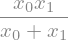

In [6]:
sympy.init_printing()
sympy.simplify(sympy.factor(best_stree.to_sympy()))

In [7]:
best_stree.clear_output()
#S.get_plotter().plot(width=8, height=6, plot_knowldege=False, model=best_stree, zoomout=1)
S.evaluate_extra(best_stree)

{'mse': 0.0, 'rmse': 0.0, 'r2': 1.0}

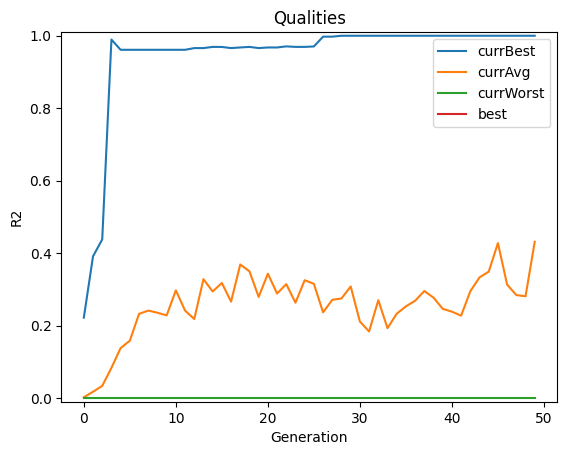

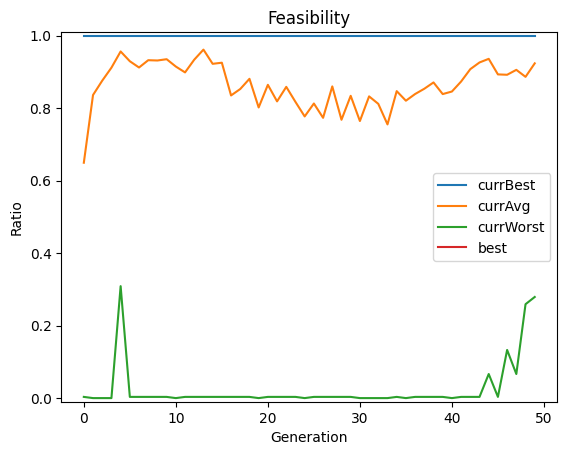

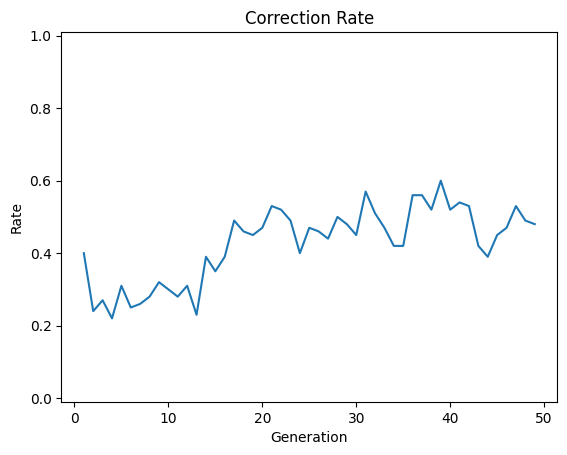

In [8]:
symb_regressor.stats.plot()

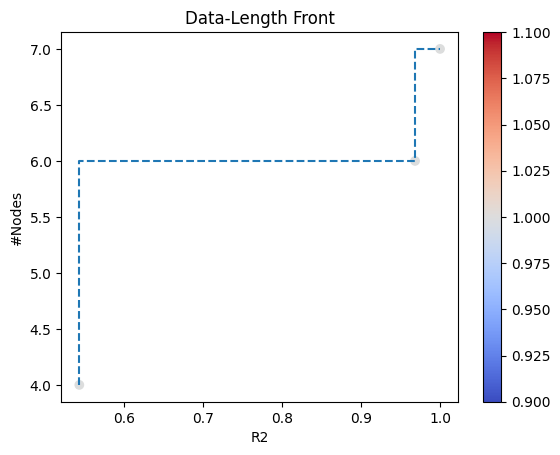

,Score,Model,Front,fpn,R2,Length,Symbset,Symbdist,Crowdist
0,0,sqrt((x1 + x0)),0,0.434531,0.543163,4,"(sqrt, +)",1,inf
1,1,((x1 * x0) / (x1 + x0)),0,0.650000,1.000000,7,"(+, *, /)",1,inf
2,2,sqrt(((x1 * x0) / 4.20)),0,0.677853,0.968361,6,"(sqrt, *)",1,2.000000
3,0,sqrt(sqrt((x0 * x1))),1,0.174940,0.233253,5,"(sqrt, *)",2,inf
4,1,((x1 * x0) / (((x1 - x0) + x0) + x0)),1,0.450000,1.000000,11,"(+, *, /)",2,inf
5,2,sqrt((x0 + (x1 + 0.50))),1,0.374819,0.535455,6,"(sqrt, +)",1,1.117052
6,3,sqrt(sqrt(sqrt(cube((x1 * x0))))),1,0.542209,0.834167,7,"(cube, sqrt, *)",1,0.886211
7,4,((x1 * x0) / (2.89 + (x1 + x0))),1,0.528648,0.961178,9,"(+, *, /)",2,0.552987
8,5,sqrt((((x0 * x1) * -3.79) / -15.03)),1,0.575623,0.959372,8,"(sqrt, *)",2,0.498982
9,0,sqrt(((x1 + 0.71) + x0)),2,0.372423,0.532033,6,"(sqrt, +)",1,inf


In [9]:
pd_data = []
front_tracker = symb_regressor.fea_front_tracker.front_tracker_a

for frontidx in range(front_tracker.nfronts):

    front = front_tracker.get_front(frontidx)
    symbset, symbdist = front_tracker.compute_symbdist(frontidx)
    crowdist = front_tracker.compute_crowdist(frontidx)
    
    for idx, (stree, data, length) in enumerate(front):
        pd_data.append(
            [idx, stree, frontidx, data*(1.-min(1.,length/20)), data, length, symbset[id(stree)], symbdist[id(stree)], crowdist[id(stree)]]
        )

front_tracker.plot(0)
pd.DataFrame(pd_data, columns=['Score', 'Model', 'Front', 'fpn', 'R2', 'Length', 'Symbset', 'Symbdist', 'Crowdist']).head(n=60)
#print(front_tracker.symbfreq.freq)
#print(symb_regressor.fea_front_tracker.front_tracker_b.symbfreq.freq)